In [1]:
import plot_settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors 

%config InlineBackend.figure_format = 'retina'

In [42]:
df_spotify = pd.read_csv("./data/cleaned/spotify_2024_MASTER.csv", encoding='latin1')
df_spotify_23 = pd.read_csv("./data/cleaned/spotify_2023_MASTER.csv", encoding='latin1')

df_spotify["artist_name_lower"] = df_spotify["Artist"].str.lower()
df_spotify_23["artist_name_lower"] = df_spotify_23["artist(s)_name"].str.lower()

In [43]:
df_spotify.head()

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,Explicit Track,artist_name_lower
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,3.904709e+08,30716.0,196631588.0,...,684.0,62.0,17598718.0,114.0,18004655.0,22931.0,4818457.0,2669262.0,0,tommy richman
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,3.237039e+08,28113.0,174597137.0,...,3.0,67.0,10422430.0,111.0,7780028.0,28444.0,6623075.0,1118279.0,1,kendrick lamar
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,6.013093e+08,54331.0,211607669.0,...,536.0,136.0,36321847.0,172.0,5022621.0,5639.0,7208651.0,5285340.0,0,artemas
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,2.031281e+09,269802.0,136569078.0,...,2182.0,264.0,24684248.0,210.0,190260277.0,203384.0,NaN,11822942.0,0,miley cyrus
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,1.070349e+08,7223.0,151469874.0,...,1.0,82.0,17660624.0,105.0,4493884.0,7006.0,207179.0,457017.0,1,eminem


In [44]:
most_streamed_24 = (df_spotify[["artist_name_lower", "Spotify Streams"]]
 .groupby("artist_name_lower").agg({"Spotify Streams": "sum"})
 .sort_values(by = ["Spotify Streams"], ascending = False)
 .reset_index())

most_streamed_23 = (df_spotify_23[["artist_name_lower", "streams"]]
 .groupby("artist_name_lower").agg({"streams": "sum"})
 .sort_values(by = ["streams"], ascending = False)
 .reset_index())

In [45]:
def get_incumbent_split(n: int = 100): 
    new_artists = set(most_streamed_24.iloc[: n]["artist_name_lower"].values) - set(most_streamed_23.iloc[: n]["artist_name_lower"].values)
    incumbents = set(most_streamed_24.iloc[: n]["artist_name_lower"].values).intersection(set(most_streamed_23.iloc[: n]["artist_name_lower"].values))
    return incumbents, new_artists, len(incumbents) / n, len(new_artists) / n

In [46]:
to_plot = dict() 
for n in range(25, 501, 25): 
    incumbents, new_artists, pct_incumbents, pct_new_artists = get_incumbent_split(n)
    to_plot.update({n: (pct_incumbents, pct_new_artists)})

labels = list(to_plot.keys())
pct_incumbents, pct_new_artists = zip(*to_plot.values())

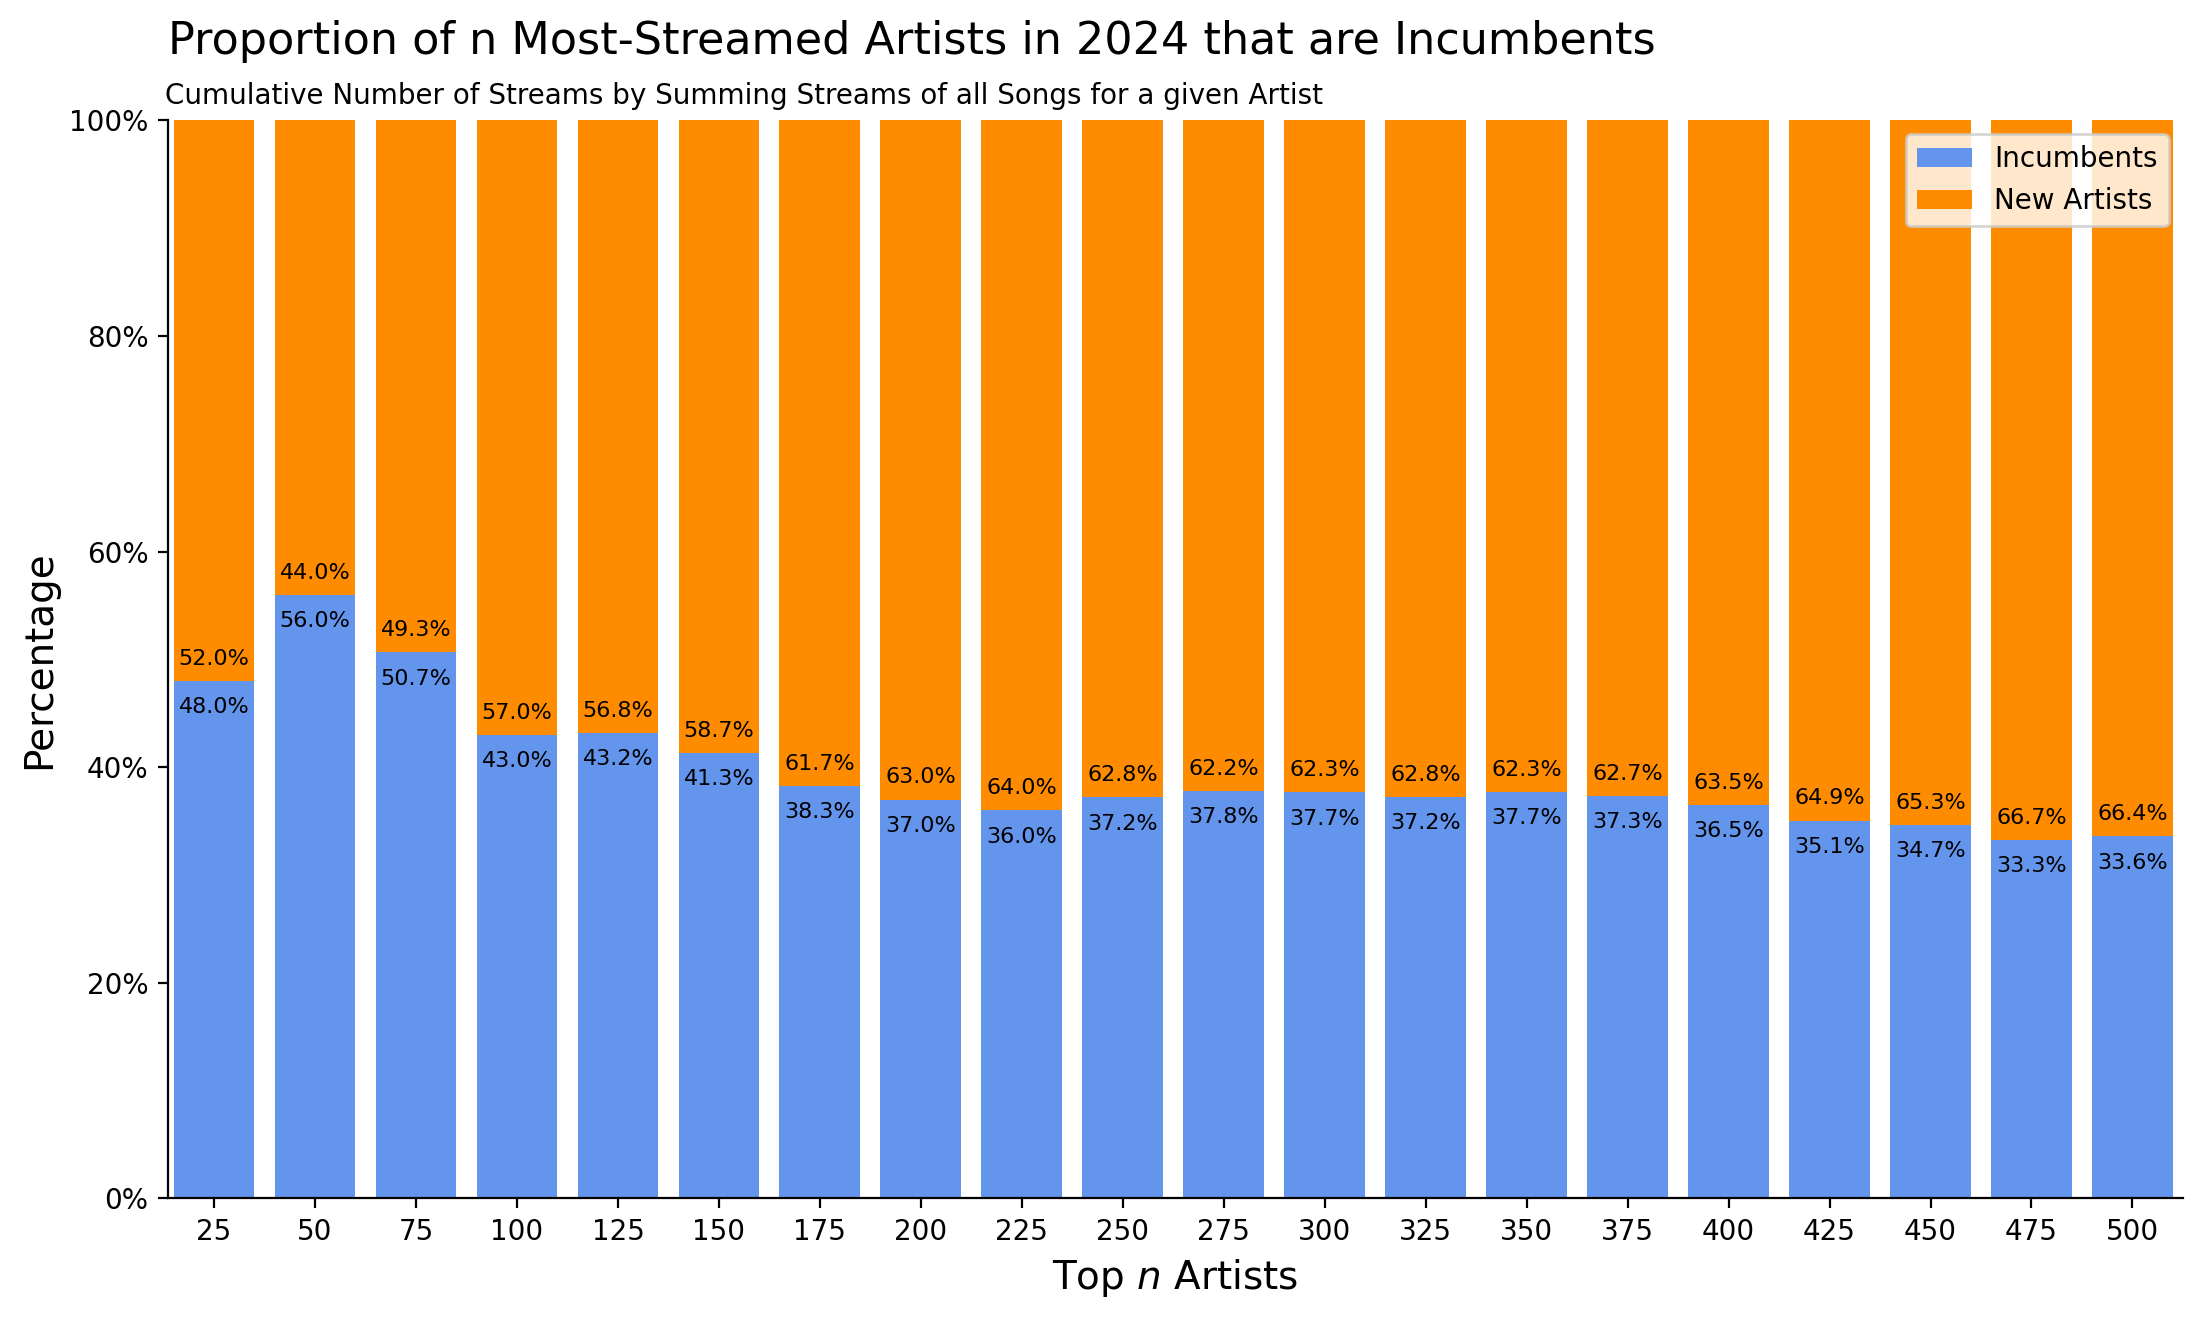

In [47]:
fig, ax = plt.subplots(figsize = (13, 7), dpi = 100)

w = 0.8
bar_positions = np.arange(len(labels))

ax.bar(bar_positions, pct_incumbents, w, label='Incumbents', color = plot_settings.colors["blue"])
ax.bar(bar_positions, pct_new_artists, w, bottom=pct_incumbents, label='New Artists', color = plot_settings.colors["orange"])

for i, n in enumerate(to_plot.keys()): 
    ax.annotate(f"{100*to_plot[n][0]:.1f}%", xy = (i, to_plot[n][0]-0.03), ha = "center", fontsize = 8)
    ax.annotate(f"{100*to_plot[n][1]:.1f}%", xy = (i, to_plot[n][0]+0.015), ha = "center", fontsize = 8)

ax.set_xlabel(r'Top $n$ Artists')
ax.set_ylabel('Percentage')
ax.set_title("Proportion of n Most-Streamed Artists in 2024 that are Incumbents\n", loc="left") 
ax.text(x = -0.49, y = 1.015, s = "Cumulative Number of Streams by Summing Streams of all Songs for a given Artist")
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels)
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylim(0, 1)
ax.set_xlim(0-w/1.75, 500/25 - 0.5)
ax.legend()

plt.savefig("top_artists.jpg")
plt.show()

In [58]:
incumbents, new_artists, pct_incumbents, pct_new_artists = get_incumbent_split(n = 200)

In [59]:
incumbent_ticktok_24 = (
    df_spotify[df_spotify["artist_name_lower"].isin(incumbents)]
    [["artist_name_lower", "Spotify Streams", "Track Score"]]
    .groupby("artist_name_lower").agg({
        "Spotify Streams": "sum", 
        "Track Score": "mean"
    })
    .reset_index()
)
# incumbent_ticktok_24["avg_views_per_post"] = incumbent_ticktok_24["TikTok Views"] / incumbent_ticktok_24["TikTok Posts"]
# incumbent_ticktok_24 = incumbent_ticktok_24[~incumbent_ticktok_24["avg_views_per_post"].isna()]

desc = incumbent_ticktok_24.describe()

In [60]:
table = incumbent_ticktok_24[incumbent_ticktok_24["Spotify Streams"] >= desc["Spotify Streams"]["75%"]] 
# table["TikTok Posts"] = table["TikTok Posts"].values / 1_000_000
table.sort_values(["Spotify Streams"], ascending = False)

,artist_name_lower,Spotify Streams,Track Score
4,bad bunny,3.705483e+10,47.300000
68,the weeknd,3.694854e+10,48.690323
17,drake,3.496216e+10,45.580952
66,taylor swift,3.447077e+10,40.900000
53,post malone,2.613747e+10,72.218182
19,ed sheeran,2.401490e+10,70.733333
2,ariana grande,2.346499e+10,51.276923
49,olivia rodrigo,1.972922e+10,54.650000
20,eminem,1.887888e+10,59.653333
24,harry styles,1.735339e+10,68.250000


In [61]:
col = "Track Score"
table = incumbent_ticktok_24[incumbent_ticktok_24[col] >= desc[col]["75%"]] 
# table["TikTok Posts"] = table["TikTok Posts"].values / 1_000_000
table.sort_values([col], ascending = False)

,artist_name_lower,Spotify Streams,Track Score
71,tones and i,3.490772e+09,117.800000
25,hozier,6.153005e+09,106.050000
23,glass animals,3.014746e+09,100.250000
28,jack harlow,4.654631e+09,90.637500
6,billie eilish,1.681183e+10,82.259259
40,lil nas x,1.315575e+10,80.580000
14,d4vd,2.289194e+09,77.566667
65,tate mcrae,6.128497e+09,77.212500
18,dua lipa,1.564931e+10,76.476471
36,kendrick lamar,1.221141e+10,73.827778


In [8]:
incumbents, new_artists, pct_incumbents, pct_new_artists = get_incumbent_split(n = 50)

In [9]:
df_spotify.columns

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'Explicit Track',
       'artist_name_lower'],
      dtype='object')

In [10]:
incumbent_ticktok_24 = (
    df_spotify[df_spotify["artist_name_lower"].isin(incumbents)]
    [["artist_name_lower", "TikTok Posts", "TikTok Views"]]
    .groupby("artist_name_lower").agg({
        "TikTok Posts": "sum", 
        "TikTok Views": "sum"
    })
    .reset_index()
)
incumbent_ticktok_24["avg_views_per_post"] = incumbent_ticktok_24["TikTok Views"] / incumbent_ticktok_24["TikTok Posts"]
incumbent_ticktok_24 = incumbent_ticktok_24[~incumbent_ticktok_24["avg_views_per_post"].isna()]

new_artist_ticktok_24 = (
    df_spotify[df_spotify["artist_name_lower"].isin(new_artists)]
    [["artist_name_lower", "TikTok Posts", "TikTok Views"]]
    .groupby("artist_name_lower").agg({
        "TikTok Posts": "sum", 
        "TikTok Views": "sum"
    })
    .reset_index()
)
new_artist_ticktok_24["avg_views_per_post"] = new_artist_ticktok_24["TikTok Views"] / new_artist_ticktok_24["TikTok Posts"]
new_artist_ticktok_24 = new_artist_ticktok_24[~new_artist_ticktok_24["avg_views_per_post"].isna()]

In [11]:
incumbent_ticktok_24.head()

,artist_name_lower,TikTok Posts,TikTok Views,avg_views_per_post
0,adele,3537129.0,1.388339e+10,3925.044644
1,arctic monkeys,77756.0,4.518427e+08,5811.033657
2,ariana grande,14757734.0,1.074612e+10,728.168519
3,avicii,5036649.0,4.552960e+09,903.966155
4,bad bunny,24314381.0,4.594701e+10,1889.705094


In [12]:
new_artist_ticktok_24.head()

,artist_name_lower,TikTok Posts,TikTok Views,avg_views_per_post
0,calvin harris,9526082.0,8.830645e+09,926.996511
1,dj snake,7600768.0,4.147600e+09,545.681706
2,drake,17378268.0,2.247737e+10,1293.418101
3,j balvin,4477816.0,1.053922e+10,2353.651259
4,karol g,20147400.0,1.450205e+10,719.797638


In [13]:
incumbent_ticktok_24["TikTok Posts"].mean() / 10_000, new_artist_ticktok_24["TikTok Posts"].mean() / 10_000

(998.8737392857144, 764.45225)

the incumbents have more outliers on ticktok in terms of number of views, and are featured in more posts. they may have more songs go hugely viral than their new artist counterparts. they enjoy loyal fanbases that bolster their online marketing through catchy clips that can be included in short video clips. 

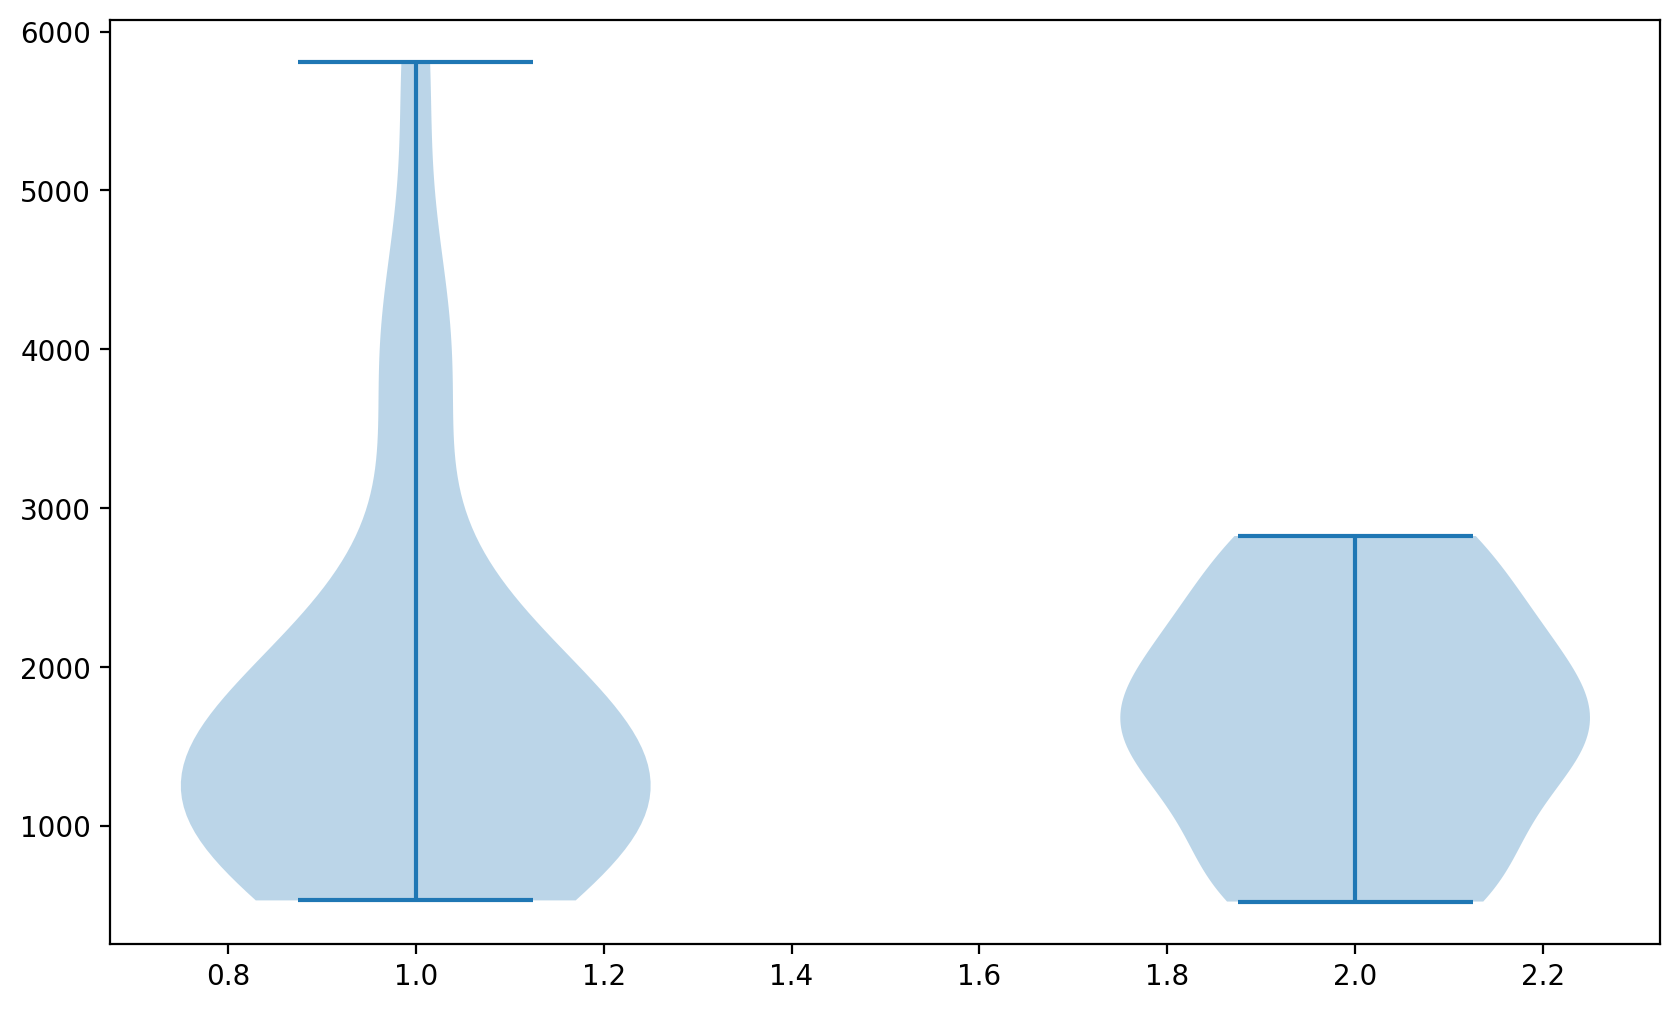

In [14]:
to_plot = [incumbent_ticktok_24.avg_views_per_post, new_artist_ticktok_24.avg_views_per_post]
plt.violinplot(to_plot)
plt.show() 

In [15]:
desc = incumbent_ticktok_24.describe()
desc

,TikTok Posts,TikTok Views,avg_views_per_post
count,2.800000e+01,2.800000e+01,28.000000
mean,9.988737e+06,1.556990e+10,1773.875060
std,6.847630e+06,1.317614e+10,1263.851748
min,7.775600e+04,4.518427e+08,531.994814
25%,4.629225e+06,6.225256e+09,998.266455
50%,9.177444e+06,1.211105e+10,1338.331078
75%,1.328328e+07,2.299086e+10,1924.747597
max,2.848977e+07,5.352624e+10,5811.033657


In [16]:
desc["TikTok Posts"]["75%"]

13283277.75

In [32]:
table = incumbent_ticktok_24[incumbent_ticktok_24["TikTok Posts"] >= desc["TikTok Posts"]["75%"]] 
table["TikTok Posts"] = table["TikTok Posts"].values / 1_000_000
table.sort_values(["TikTok Posts"], ascending = False)

/var/folders/lb/pskgtvls62dbtqb4_b8_f_8c0000gn/T/ipykernel_5288/3594547849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["TikTok Posts"] = table["TikTok Posts"].values / 1_000_000


,artist_name_lower,TikTok Posts,TikTok Views,avg_views_per_post
9,doja cat,28.489769,5.352624e+10,1878.788243
4,bad bunny,24.314381,4.594701e+10,1889.705094
11,ed sheeran,19.346816,2.214167e+10,1144.460461
19,lil nas x,16.191629,2.553842e+10,1577.260828
10,dua lipa,16.049684,1.990364e+10,1240.126540
2,ariana grande,14.757734,1.074612e+10,728.168519
25,taylor swift,13.398495,3.002006e+10,2240.554445


In [34]:
table = incumbent_ticktok_24[incumbent_ticktok_24["TikTok Views"] >= desc["TikTok Views"]["75%"]]
table["TikTok Views"] = table["TikTok Views"].values / 10_000_000
table.sort_values(["TikTok Views"], ascending = False)

/var/folders/lb/pskgtvls62dbtqb4_b8_f_8c0000gn/T/ipykernel_5288/677295540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["TikTok Views"] = table["TikTok Views"].values / 10_000_000


,artist_name_lower,TikTok Posts,TikTok Views,avg_views_per_post
9,doja cat,28489769.0,5352.624304,1878.788243
4,bad bunny,24314381.0,4594.700963,1889.705094
25,taylor swift,13398495.0,3002.005752,2240.554445
13,harry styles,6373002.0,2823.561266,4430.504284
21,olivia rodrigo,7612599.0,2763.098879,3629.639337
7,bts,13244872.0,2688.543593,2029.875104
19,lil nas x,16191629.0,2553.842217,1577.260828


In [39]:
table = incumbent_ticktok_24[incumbent_ticktok_24["avg_views_per_post"] >= desc["avg_views_per_post"]["75%"]]
table["avg_views_per_post"] = table["avg_views_per_post"].values
table.sort_values(["avg_views_per_post"], ascending = False)

/var/folders/lb/pskgtvls62dbtqb4_b8_f_8c0000gn/T/ipykernel_5288/3472288932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["avg_views_per_post"] = table["avg_views_per_post"].values


,artist_name_lower,TikTok Posts,TikTok Views,avg_views_per_post
1,arctic monkeys,77756.0,4.518427e+08,5811.033657
13,harry styles,6373002.0,2.823561e+10,4430.504284
0,adele,3537129.0,1.388339e+10,3925.044644
21,olivia rodrigo,7612599.0,2.763099e+10,3629.639337
12,eminem,3399021.0,8.915579e+09,2622.984492
25,taylor swift,13398495.0,3.002006e+10,2240.554445
7,bts,13244872.0,2.688544e+10,2029.875104
